In [149]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from google.colab import drive
drive.mount('/content/drive')
parquet_file='/content/drive/MyDrive/Software Engineer Assessment/data/game_state_frame_data.parquet'
#curr_dir=os.getcwd()
class ProcessGameState:
  class Point:
      def __init__(self, x, y):
          self.x = x
          self.y = y
  
  class line:
      def __init__(self, p1, p2):
          self.p1 = p1
          self.p2 = p2
  
  def __init__(self, parquet_file):
      self.MatchData=pd.read_parquet(parquet_file,engine='auto') 
      self.Team2onT=self.MatchData.loc[(self.MatchData['team'] == 'Team2')&(self.MatchData['side'] == 'T') ]
      self.T2onTSiteB=self.Team2onT.loc[(self.Team2onT['area_name']=='BombsiteB')&(self.Team2onT['bomb_planted']==False)]\
      [['player', 'clock_time', 'round_num', 'inventory']].sort_values(['round_num', 'clock_time'], ascending=[True, False])
      self.Team2onCT=self.MatchData.loc[(self.MatchData['team'] == 'Team2')&(self.MatchData['side'] == 'CT') ]
      self.T2onCTSiteB=self.Team2onCT.loc[(self.Team2onCT['area_name']=='BombsiteB')&(self.Team2onCT['bomb_planted']==False)] [['player', 'clock_time', 'round_num', 'x', 'y']]
  
  def onLine(l1, p):
      # Check whether p is on the line or not
      if (
          p.x <= max(l1.p1.x, l1.p2.x)
          and p.x <= min(l1.p1.x, l1.p2.x)
          and (p.y <= max(l1.p1.y, l1.p2.y) and p.y <= min(l1.p1.y, l1.p2.y))
      ):
          return True
      return False
  
  def direction(a, b, c):
      val = (b.y - a.y) * (c.x - b.x) - (b.x - a.x) * (c.y - b.y)
      if val == 0:
          # Collinear
          return 0
      elif val < 0:
          # Anti-clockwise direction
          return 2
      # Clockwise direction
      return 1
  
  def isIntersect(l1, l2):
      dir1 = ProcessGameState.direction(l1.p1, l1.p2, l2.p1)
      dir2 = ProcessGameState.direction(l1.p1, l1.p2, l2.p2)
      dir3 = ProcessGameState.direction(l2.p1, l2.p2, l1.p1)
      dir4 = ProcessGameState.direction(l2.p1, l2.p2, l1.p2)
      if dir1 != dir2 and dir3 != dir4:
          return True
      if dir1 == 0 and ProcessGameState.onLine(l1, l2.p1):
          return True
      if dir2 == 0 and ProcessGameState.onLine(l1, l2.p2):
          return True
      if dir3 == 0 and ProcessGameState.onLine(l2, l1.p1):
          return True
      if dir4 == 0 and ProcessGameState.onLine(l2, l1.p2):
          return True 
      return False
#   def is_within_polygon(polygon, point):
#     A = []
#     B = []
#     C = []  
#     for i in range(len(polygon)):
#         p1 = polygon[i]
#         p2 = polygon[(i + 1) % len(polygon)]
        
#         a = -(p2.y - p1.y)
#         b = p2.x - p1.x
#         c = -(a * p1.x + b * p1.y)
#         A.append(a)
#         B.append(b)
#         C.append(c)

#     D = []
#     for i in range(len(A)):
#         d = A[i] * point.x + B[i] * point.y + C[i]
#         D.append(d)

#     t1 = all(d >= 0 for d in D)
#     t2 = all(d <= 0 for d in D)
#     return t1 or t2
  def is_within_polygon(poly, p):
      n=len(poly)
      if n < 3:
          return False
      exline = ProcessGameState.line(p, ProcessGameState.Point(9999, p.y))
      count = 0
      i = 0
      while True:

          side = ProcessGameState.line(poly[i], poly[(i + 1) % n])
          if ProcessGameState.isIntersect(side, exline):
              if (ProcessGameState.direction(side.p1, p, side.p2) == 0):
                  return ProcessGameState.onLine(side, p);
              count += 1
          
          i = (i + 1) % n;
          if i == 0:
              break
  
      # When count is odd
      return count & 1;
  
  def BoundaryCheck(Vertices, PointOfInterest, ZBound=[285, 421]):
    if PointOfInterest[2]<ZBound[0] or PointOfInterest[2]>ZBound[1]:
      return False
    if len(Vertices)>3:
      return ProcessGameState.is_within_polygon(Vertices,ProcessGameState.Point(PointOfInterest[0],PointOfInterest[1]))
    else:
      return False
  def getWeapons(dfRow):
    WeaponClasses=set()
    if dfRow.inventory is not None:
      for weapon in dfRow.inventory:
        WeaponClasses.add(weapon['weapon_class'])
    return WeaponClasses
  def col_to_numpy(df, col):
    return df[col].to_numpy()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?

In [150]:
Vertices=[ProcessGameState.Point(-1735, 250), ProcessGameState.Point(-2024, 398), ProcessGameState.Point(-2806, 742), ProcessGameState.Point(-2472, 1233), ProcessGameState.Point(-1565, 580)]
Rounds=set()
ZBound=[285, 421]
PGS=ProcessGameState(parquet_file)
for index, row in PGS.Team2onT.iterrows():
  PoI=[row['x'],row['y'],row['z']]
  if ProcessGameState.BoundaryCheck(Vertices,PoI,ZBound):
    Rounds.add(row['round_num'])
TRounds=len(PGS.Team2onT.round_num.unique())

print("Out of a total of {} T Rounds from Team 2 , they entered light blue boundary in Round(s) {}".format(TRounds,Rounds))
print("And since they entered the boundary only in Rounds 16, which is a pistol rounds, this is not a common strategy that Team 2 on T tends to deploy")

Out of a total of 15 T Rounds from Team 2 , they entered light blue boundary in Round(s) {16}
And since they entered the boundary only in Rounds 16, which is a pistol rounds, this is not a common strategy that Team 2 on T tends to deploy


# What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with (at) least 2 rifles or SMGs?

In [151]:
# out=set()
# for index, row in PGS.MatchData.iterrows():
#   out=out.union(ProcessGameState.getWeapons(row))
# print(out)
RoundsRecorded=[]
Timer=[]

BwithPrimaryWeapon=PGS.T2onTSiteB.copy(deep=True)
for index, row in BwithPrimaryWeapon.iterrows():
  WeaponClasses=ProcessGameState.getWeapons(row)
  if 'Rifle' not in WeaponClasses and 'SMG' not in WeaponClasses:
    BwithPrimaryWeapon.drop(index, inplace=True)
for index, row in BwithPrimaryWeapon.iterrows():
  if row.round_num not in RoundsRecorded:
    BPlayerNum=len(BwithPrimaryWeapon.loc[(BwithPrimaryWeapon.clock_time==row.clock_time) & (BwithPrimaryWeapon.round_num==row.round_num)].player.unique())
    if BPlayerNum>=2:
      Timer.append(row.clock_time)
      RoundsRecorded.append(row.round_num)
Tsecond=0
for T in Timer:
  Tsecond+=int(T[0:2])*60+int(T[3:5])
AvgT=round(Tsecond/len(Timer))
AvgTimer=str(AvgT//60)+":"+str(AvgT%60)

print("Team 2 on T side enters BombsiteB in Rounds {} with (at) least 2 rifles or SMGs when the timer are {} respectively".format(RoundsRecorded,Timer))
print("Therefore the average timer is round {}".format(AvgTimer))


Team 2 on T side enters BombsiteB in Rounds [21, 28, 30] with (at) least 2 rifles or SMGs when the timer are ['01:35', '01:26', '01:17'] respectively
Therefore the average timer is round 1:26


# Now that we’ve gathered data on Team2 T side, let's examine their CT(counter-terrorist) Side. Using the same data set, tell our coachingstaff where you suspect them to be waiting inside “BombsiteB”



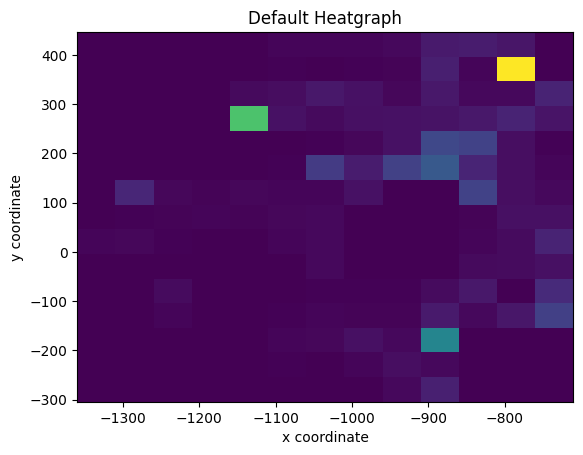

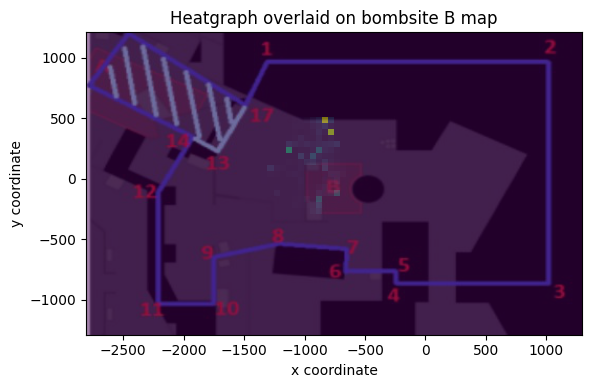

From the overlaid map, the results seem to be intuitively less accurate as we usually assume the heatmap should show more density in the area behind bombsite B barrel and around water
This might due to the nature of the data given or due to the bias caused during scaling the bombsite B map as I scaled using the xy coordinates from boundary point 15, 13, and 16


In [152]:

arrayX=ProcessGameState.col_to_numpy(PGS.T2onCTSiteB, 'x')
arrayY=ProcessGameState.col_to_numpy(PGS.T2onCTSiteB, 'y')

plt.hist2d(arrayX,arrayY,bins=[np.arange(arrayX.min(),arrayX.max(),50), np.arange(arrayY.min(),arrayY.max(),50)])
plt.title("Default Heatgraph")
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()

x_max = 1336.66
x_min = -2806 # x coordinate from point 15
y_max = 1233 # y coordinate from point 16
y_min= -1288
plt.hist2d(arrayX,arrayY,bins=[np.arange(x_min,x_max, 50), np.arange(y_min,y_max, 50)],alpha = 0.5, zorder =2)

extent = [x_min, x_max, y_min, y_max]
#map_img = mpimg.imread('/content/drive/MyDrive/Software Engineer Assessment/map/de_overpass_radar.jpeg')
map_img = mpimg.imread('/content/drive/MyDrive/Software Engineer Assessment/map/BombsiteB.jpg')
plt.imshow(map_img, extent=extent, zorder =1)
plt.title("Heatgraph overlaid on bombsite B map")
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()
print('From the overlaid map, the results seem to be intuitively less accurate as we usually assume the heatmap should show more density in the area behind bombsite B barrel and around water')
print('This might due to the nature of the data given or due to the bias caused during scaling the bombsite B map as I scaled using the xy coordinates from boundary point 15, 13, and 16')

# Propose a solution to your product manager that:
# a. could allow our coaching staff to request or acquire the output themselves
# b. takes less than 1 weeks worth of work to implement

Build a lightweight GUI utilizing standard python library tkinter (will use different GUI library if tkinter interface looks too outdated) that is capable of 
*   selecting different parquet_file that contains the match data locally
*   filtering the data based on drop down menus (e.g. different map location) / selected range (e.g. hp)
*  storing all csgo maps and their corresponding edge coordinates as presets
*  Generating outputs and achieving different funtionalities based on buttons that coaching staff press on the interface

A more complex solution can be to build a web interface hosted on AWS Beanstalk that can do the same data processing and output generation based on the uploaded file with python flask as backend and bootstrap as front end and user interface. 

